# Clasificación rápida en ALeRCE utilizando selección de características y algoritmos genéticos.

Integrantes: Joaquín Cubelli - Tomás de la Sotta

Profesor de Cátedra: Pablo Estévez<br>
Profesor Auxiliar: Ignacio Reyes<br>
Ayudantes: Francisca Cona, Jhon Intriago, Pablo Montero, Óscar Pimentel, Esteban Reyes, Mauricio Romero

El broker astronómico ALeRCE clasifica objetos en tiempo real todas las noches. Para ello utiliza dos modelos, un clasificador basado en estampillas para detección rápida de transientes y un clasificador basado en curvas de luz que utiliza una taxonomía detallada. El clasificador de curvas de luz, descrito en Sánchez-Sáez et al. (2020), consiste en la extracción de múltiples características a partir de las curvas de luz (y otras fuentes de datos) y un modelo basado en Random Forests.

El objetivo de este proyecto es reducir el número de características utilizadas por el clasificador de curvas de luz de ALeRCE, explorando el compromiso entre el desempeño en clasificación y el costo computacional asociado.

La primera etapa del proyecto consiste en **evaluar la estrategia greedy para seleccionar las características más relevantes al momento de clasificar**. En esta estrategia se explorará una característica a la vez, buscando cuál de ellas ayuda más al desempeño del modelo cuando es agregada al conjunto de características utilizadas. También se deberá probar comenzando con todas las características y removiendo una característica a la vez. 

La segunda etapa consiste en **formular el problema como la optimización de una figura de mérito y resolver mediante algoritmos genéticos**. Lo que *se busca minimizar son dos cantidades, el error de clasificación y el tiempo requerido para la clasificación*. Se propone construir una función de fitness que combine ambos costos y luego explorar el frente de Pareto modificando la manera en que se ponderan ambos términos.

Ref: Sánchez-Sáez, P., et al. "Alert Classification for the ALeRCE Broker System: The Light Curve Classifier." arXiv preprint arXiv:2008.03311 (2020).
Ref: Huang, Cheng-Lung, and Chieh-Jen Wang. "A GA-based feature selection and parameters optimization for support vector machines." Expert Systems with applications 31.2 (2006): 231-240. Nota: Tomar como referencia, no como pauta a la cual seguir al pie de la letra. 

Proyecto semestral: https://docs.google.com/document/d/1pz1Yua5fkzJQAhDPjIAwJjJXUPnKswe7gRMs_D2-ixA/edit

Requisitos entrega Intermedia: https://docs.google.com/document/d/1kgTPnFyniYfJPlIaA2JUxTBbzQ6Erax6sKyxXOmG-0Q/edit

Indicaciones proyecto: https://docs.google.com/document/d/10-ZcclkeuGaviFsalC4wnTtrZMiitumQKaUmijk1tsA/edit

## Imports de librerías y otros archivos de python

In [1]:
# Correr una vez.

# !pip install --upgrade pip
# !pip install pyarrow
# !pip install -U imbalanced-learn

In [2]:
# Imports:
from dicts.features_packs import feature_packs
from dicts.banned_features import banned_features
from dicts.Dict import Dict
from dataset_creation import *

# Procesamiento de datos.
from pathlib import Path
import os.path

import matplotlib as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq

# import tensorflow as tf
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier

# Resultados

from imblearn.metrics import sensitivity_specificity_support as sss
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.model_selection import cross_validate
    #import itertools
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

from bins.Tree import get_tree_data

In [3]:
#dataset = get_dataset(Joaquin = False) # Ejecutar si no existe el dataset, y mover el csv al directorio padre (>100 MB, no entra en github).

In [4]:
dataset = pd.read_csv('../ALeRCE.csv') # Se ejecuta el archivo en el directorio padre.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(dataset.select_dtypes(include=[np.number]), dataset['classALeRCE'], test_size=0.33, random_state=42)

## Clasificador inicial, para ver el ranking de features para realizar el feature selection.

In [6]:
clf=BalancedRandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            class_weight=None,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

clf.fit(X_train, y_train)

BalancedRandomForestClassifier(criterion='entropy', n_estimators=500, n_jobs=-1)

In [7]:
y_pred = clf.predict(X_test)

classes = clf.classes_

featuresCopy = np.copy(dataset.columns[1:])
featuresCopy = np.delete(featuresCopy, np.where(featuresCopy == 'classALeRCE'))

fI = clf.feature_importances_
feature_importance = np.copy(fI)

In [8]:
ImportanceRank = []

while not np.all(fI == -1):
    maxArg = np.argmax(fI)
    ImportanceRank.append(featuresCopy[maxArg])
    fI[maxArg] = -1

Visualizemos tanto la estructura del árbol (https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c) y de las distintas features, y analizaremos los datos (https://medium.com/@smollaha/imbalanced-data-visualization-and-random-forest-25cbff51f711)

Text(30.5, 0.5, 'True label')

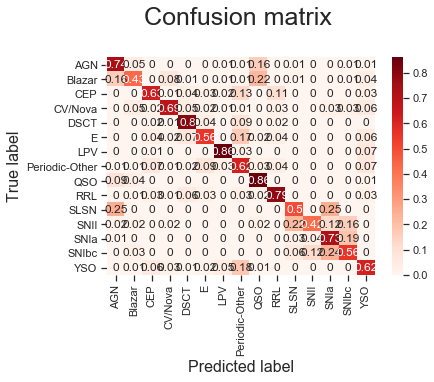

In [9]:
cm = confusion_matrix(y_test, y_pred) 
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(np.round(cm, 2), index = classes, columns = classes)

g = sns.heatmap(df, annot=True, cmap="Reds")

plt.rcParams["figure.figsize"] = (10,10)

g.set_yticklabels(g.get_yticklabels(), rotation = 0)

#Estandar en 20, 20

plt.title('Confusion matrix \n', size=25)
plt.xlabel('Predicted label', size=16)
plt.ylabel('True label', size=16)



In [10]:
scoring = ['precision_macro', 'recall_macro', 'accuracy', 'f1_macro']

precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')
f1 = f1_score(y_test, y_pred, average = 'weighted')
accuracy = accuracy_score(y_test, y_pred)

print('Precision: {}  ({}%)'.format(precision, int(precision*100)))
print('Recall:    {}  ({}%)'.format(recall, int(recall*100)))
print('F1-score:  {}  ({}%)'.format(f1, int(f1*100)))
print('Accuracy:  {}  ({}%)'.format(accuracy, int(accuracy*100)))

Precision: 0.8774047794259011  (87%)
Recall:    0.72418206953049  (72%)
F1-score:  0.7746747327853938  (77%)
Accuracy:  0.72418206953049  (72%)


## Feature selection greedy:

- Tener implementado feature selection greedy basado en la importancia dada por Random Forest. Mostrar curva accuracy vs número de packs y accuracy vs tiempo de cómputo asociado.

In [11]:
train = False
ThreadAccuracy, ThreadPrecision, ThreadRecall, Threadf1 = get_tree_data(dataset, ImportanceRank, train)

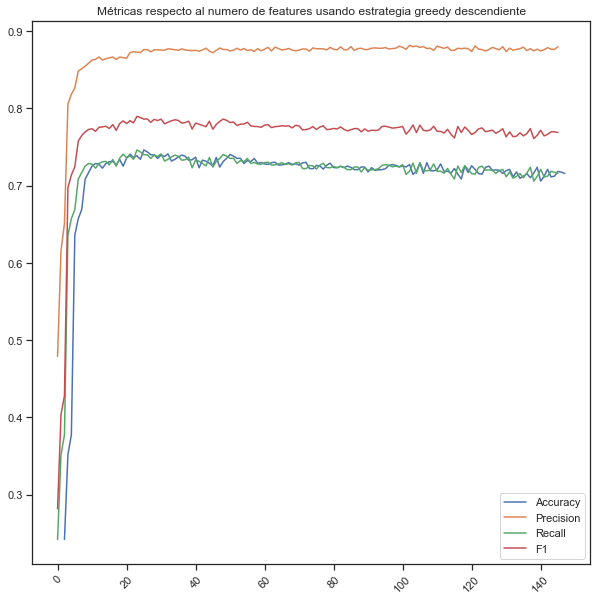

In [12]:
plt.plot(np.arange(2,148), ThreadAccuracy)
plt.plot(ThreadPrecision)
plt.plot(ThreadRecall)
plt.plot(Threadf1)
plt.legend(('Accuracy', 'Precision', 'Recall', 'F1'))
plt.title('Métricas respecto al numero de features usando estrategia greedy descendiente')
plt.xticks(rotation=45)
plt.show()

In [13]:
# Codigo no optimizado por Joaquin que realiza el feature selection por característica (at least works).

featuresCopy = np.copy(dataset.columns[1:])
featuresCopy = np.delete(featuresCopy, np.where(featuresCopy == 'classALeRCE'))

Importancia = pd.DataFrame(clf.feature_importances_, columns=['Importancia'])
Importancia.index = featuresCopy

fImax=[]
packsNames=[]
time=[]
for i in feature_packs:
    frac = 0
    for j in range(len(feature_packs[i])-1):
        frac += Importancia.loc[feature_packs[i][j]]['Importancia']
    time.append(feature_packs[i][-1])
    fImax.append(frac)
    packsNames.append(i)
    
I_Packs = pd.DataFrame(fImax, columns=['Importancia'], index=packsNames)
I_Packs['Tiempo'] = time

accuracy = []
f1 = []
precision = []
recall = []
tiempo = []

ImportanciaRank = I_Packs

pass

for i in range(len(I_Packs['Importancia'])):
    print('Packs usados: '+str(len(ImportanciaRank)))
    selected_features = []
    t = 0
    for i in ImportanciaRank.index:
        for j in range(len(feature_packs[i])-1):
            selected_features.append(feature_packs[i][j])
        t+=feature_packs[i][-1]
    tiempo.append(t)
    print('Numero de features: '+str(len(selected_features)))
    X_train2 = X_train[selected_features]
    X_test2 = X_test[selected_features]
    clf.fit(X_train2, y_train)
    y_pred = clf.predict(X_test2)
    a_score = accuracy_score(y_test, y_pred)
    f_score = f1_score(y_test, y_pred, average='macro')
    p_score = precision_score(y_test, y_pred, average='macro')
    r_score = recall_score(y_test, y_pred, average='macro')
    ImportanciaRank = ImportanciaRank.loc[ImportanciaRank['Importancia']!=ImportanciaRank['Importancia'].min()]
    accuracy.insert(0, a_score)
    f1.insert(0, f_score)
    precision.insert(0, p_score)
    recall.insert(0, r_score)
    print('Accuracy:  {}  ({}%)'.format(a_score, int(a_score*100)))
    print('Precision:  {}  ({}%)'.format(p_score, int(p_score*100)))
    print('Recall:  {}  ({}%)'.format(r_score, int(r_score*100)))
    print('F1-score:  {}  ({}%)'.format(f_score, int(f_score*100)))
    print('')
    if len(ImportanciaRank)>0:
        print('Pack Eliminado: ',ImportanciaRank.loc[ImportanciaRank['Importancia']==ImportanciaRank['Importancia'].min()].index[0])

Packs usados: 36
Numero de features: 148
Accuracy:  0.7122779171573396  (71%)
Precision:  0.45893524761228377  (45%)
Recall:  0.6386196067701284  (63%)
F1-score:  0.46896374539722163  (46%)

Pack Eliminado:  PairSlopeTrend
Packs usados: 35
Numero de features: 146


KeyboardInterrupt: 

In [ ]:
plt.plot(np.arange(1,37), accuracy)
plt.plot(precision)
plt.plot(recall)
plt.plot(f1)
plt.legend(('Accuracy', 'Precision', 'Recall', 'F1'))
plt.title('Métricas respecto al numero de features usando estrategia greedy descendiente para distintos packs de características')
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.plot(tiempo, accuracy[::-1])
plt.plot(tiempo, precision[::-1])
plt.plot(tiempo, recall[::-1])
plt.plot(tiempo, f1[::-1])
plt.legend(('Accuracy', 'Precision', 'Recall', 'F1'))
plt.title('Métricas respecto al numero de features usando estrategia greedy descendiente para tiempos de computo totales')
plt.xticks(rotation=45)
plt.show()

In [ ]:
tiempo

## Algoritmo Genético:

Se utiliza la librería DEAP para realizar la búsqueda de features utilizando algoritmos geneticos, para esto, se tienen en cuenta los siguientes parámetros para la función de fitness; el accuracy y el tiempo de computo. Se busca maximizar el accuracy y minimizar el tiempo de computo de los packs de features utilizados.
En el diccionario feature_packs, bajo cada feature pack, se encuentra el tiempo de cómputo en el ultimo elemento.

- Implementar selección de características con algoritmos genéticos y probarlo. Obtener resultados preliminares y construir curvas para comparar con estrategia greedy. Reportar curvas de fitness vs generaciones con mejor fitness, peor fitness y fitness promedio.
- Revisar material de estudio para entender conceptos básicos de algoritmos genéticos. Si tienen cualquier duda contáctenme.
- Al parecer la librería más popular de computación evolutiva en python es DEAP https://deap.readthedocs.io/en/master/ Siempre pueden implementar la optimización con algoritmos genéticos desde cero, pero es más fácil si se apoyan en una librería.
- Les recomiendo usar para el genotipo una codificación binaria, donde cada bit indica si un pack está presente o no.
- En la función de fitness van a tener que entrenar el RF con los packs indicados por el genotipo y luego calcular el accuracy (o la métrica que elijan para indicar performance de clasificación). Después deberán calcular el costo computacional de los features usados. Finalmente deben construir un puntaje de fitness combinando ambos valores (transformar en un problema mono-objetivo), teniendo cuidado de que las escalas de ambos términos sean comparables para que ambos contribuyan en el proceso de optimización.

Joaquín - Encontré la implementación de DEAP con una regresion logistica 

In [14]:
from deap import creator, base, tools, algorithms
import random
import math

In [15]:
X_trainAndTest, X_validation, y_trainAndTest, y_validation = train_test_split(dataset.select_dtypes(include=[np.number]), dataset['classALeRCE'], test_size=0.2, random_state=42)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_trainAndTest, y_trainAndTest, test_size=0.3, random_state=42)

In [17]:
AllPacks = [] # Como no se puede llamar al diccionario por indice, se crea una lista que soluciona ese problema.
for pack in feature_packs:
    AllPacks.append(pack)

In [18]:
def getFitness(individual, X_train, X_test, y_train, y_test):
    # Packs de caracteristicas a utilizar.
    packs = [AllPacks[index] for index in range(len(individual)) if individual[index] == 1]
    print('Individuo con siguientes packs:')
    print(individual)
    cols = []
    t = 0
    for i in packs:
        for j in range(len(feature_packs[i])-1):
            cols.append(feature_packs[i][j])
        t+=feature_packs[i][-1]
    print('Tiempo cómputo: ', t)
    X_trainParsed = X_train[cols]
    X_testParsed = X_test[cols]
    # Entrenar y evaluar
    clf.fit(X_trainParsed, y_train)
    y_pred = clf.predict(X_testParsed)
    accuracy = accuracy_score(y_test, y_pred)
    print('Accurcy calculada: ', accuracy)
    
    fitness = accuracy*-math.log(t, 10)
    print('Fitness calculada: ', fitness)
    print('')
    
    return fitness, accuracy

In [19]:
#========DEAP GLOBAL VARIABLES (viewable by SCOOP)========

# Create Individual
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Create Toolbox
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(feature_packs))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Continue filling toolbox...
toolbox.register("evaluate", getFitness, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [20]:
def getHof(): # Hall of fame

    # Initialize variables to use eaSimple
    numPop = 100
    numGen = 10
    pop = toolbox.population(n=numPop)
    hof = tools.HallOfFame(numPop * numGen)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # Launch genetic algorithm
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=numGen, stats=stats, halloffame=hof, verbose=True)

    # Return the hall of fame
    return hof

In [21]:
def getMetrics(hof):

    # Get list of percentiles in the hall of fame
    percentileList = [i / (len(hof) - 1) for i in range(len(hof))]
    
    # Gather fitness data from each percentile
    testAccuracyList = []
    testFitnessList = []
    validationAccuracyList = []
    validationFitnessList = []
    individualList = []
    for individual in hof:
        testFitness = individual.fitness.values
        validationFitness  = getFitness(individual, X_trainAndTest, X_validation, y_trainAndTest, y_validation)
        testFitnessList.append(testFitness[0])
        validationFitnessList.append(validationFitness[0])
        individualList.append(individual)
    testFitnessList.reverse()
    validationFitnessList.reverse()
    return testFitnessList, validationFitnessList, individualList, percentileList

In [22]:
individual = [1 for i in range(len(AllPacks))]
testFitness = getFitness(individual, X_train, X_test, y_train, y_test)
validationFitness = getFitness(individual, X_trainAndTest, X_validation, y_trainAndTest, y_validation)

Individuo con siguientes packs:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Tiempo cómputo:  0.26646172798665807
Accurcy calculada:  0.7049526558484988
Fitness calculada:  0.4049002450129757

Individuo con siguientes packs:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Tiempo cómputo:  0.26646172798665807
Accurcy calculada:  0.7130607417419954
Fitness calculada:  0.40955724706499524



In [23]:
print('Inicialización Hall of Fame: Toma varias horas\n')
hof = getHof()

Inicialización Hall of Fame: Toma varias horas

Individuo con siguientes packs:
[0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0]
Tiempo cómputo:  0.017118539293565185
Accurcy calculada:  0.6023091273892076
Fitness calculada:  1.0639991279913077

Individuo con siguientes packs:
[0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1]
Tiempo cómputo:  0.13474008887604944
Accurcy calculada:  0.6605653138090042
Fitness calculada:  0.5750242000048326

Individuo con siguientes packs:
[1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1]
Tiempo cómputo:  0.02449778100348836
Accurcy calculada:  0.5257136822837833
Fitness calculada:  0.8468581090153984

Individuo con siguientes packs:
[1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1]
Tiempo cómputo:  0.13384418371565512
Ac

Accurcy calculada:  0.63184202189447
Fitness calculada:  0.37533576591237483

Individuo con siguientes packs:
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1]
Tiempo cómputo:  0.09312989507732589
Accurcy calculada:  0.5006512020838466
Fitness calculada:  0.5161267744838323

Individuo con siguientes packs:
[0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1]
Tiempo cómputo:  0.24305303544997922
Accurcy calculada:  0.627442007814425
Fitness calculada:  0.3854369670394015

Individuo con siguientes packs:
[0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0]
Tiempo cómputo:  0.025350640904406467
Accurcy calculada:  0.621387588440283
Fitness calculada:  0.9917414615465406

Individuo con siguientes packs:
[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0]
Tiempo cómp

Accurcy calculada:  0.5287056918582139
Fitness calculada:  0.4940223645612711

Individuo con siguientes packs:
[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1]
Tiempo cómputo:  0.13993936433479456
Accurcy calculada:  0.6874229997535992
Fitness calculada:  0.5871005580930813

Individuo con siguientes packs:
[1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.008653354685793216
Accurcy calculada:  0.526945686226196
Fitness calculada:  1.086991726546016

Individuo con siguientes packs:
[1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
Tiempo cómputo:  0.011434653120809442
Accurcy calculada:  0.5290224928719772
Fitness calculada:  1.027243712062672

Individuo con siguientes packs:
[1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]
Tiempo cóm

Accurcy calculada:  0.6241331972262312
Fitness calculada:  0.5762293386773093

Individuo con siguientes packs:
[0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0]
Tiempo cómputo:  0.08296550517406923
Accurcy calculada:  0.6384948431834981
Fitness calculada:  0.6902783316564216

Individuo con siguientes packs:
[0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0]
Tiempo cómputo:  0.24759500929216996
Accurcy calculada:  0.723151114083565
Fitness calculada:  0.43841623021704695

Individuo con siguientes packs:
[1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
Tiempo cómputo:  0.195046346088587
Accurcy calculada:  0.6591573093033898
Fitness calculada:  0.4679108453066684

gen	nevals	avg     	std     	min     	max    
0  	100   	0.626947	0.213309	0.375336	1.37708
Individuo con siguientes packs:
[1, 0, 1, 0, 0, 1, 0, 1, 0, 

Accurcy calculada:  0.6220915906930902
Fitness calculada:  1.0957381882306745

Individuo con siguientes packs:
[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1]
Tiempo cómputo:  0.0263262786717477
Accurcy calculada:  0.5376817205815059
Fitness calculada:  0.8493277054009908

Individuo con siguientes packs:
[1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0]
Tiempo cómputo:  0.027766095671239888
Accurcy calculada:  0.5577809848991517
Fitness calculada:  0.8681778390591071

Individuo con siguientes packs:
[1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0]
Tiempo cómputo:  0.019316964516922407
Accurcy calculada:  0.5193072617832377
Fitness calculada:  0.8901243856851303

Individuo con siguientes packs:
[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0]
Tiempo c

Accurcy calculada:  0.7070646626069204
Fitness calculada:  0.4427131360080661

Individuo con siguientes packs:
[0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]
Tiempo cómputo:  0.07300733923876035
Accurcy calculada:  0.5925234960751874
Fitness calculada:  0.6734820428429799

Individuo con siguientes packs:
[0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.012252551354236987
Accurcy calculada:  0.6025555281776902
Fitness calculada:  1.1519496720975506

Individuo con siguientes packs:
[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0]
Tiempo cómputo:  0.12674902829564325
Accurcy calculada:  0.5652082086662678
Fitness calculada:  0.5070230539151184

Individuo con siguientes packs:
[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
Tiempo c

Accurcy calculada:  0.5528177690168609
Fitness calculada:  1.0835943223179474

Individuo con siguientes packs:
[0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1]
Tiempo cómputo:  0.14089701938558175
Accurcy calculada:  0.6656693301418565
Fitness calculada:  0.5665499647528515

Individuo con siguientes packs:
[0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1]
Tiempo cómputo:  0.029272873027171797
Accurcy calculada:  0.6231123939596607
Fitness calculada:  0.955564447625532

Individuo con siguientes packs:
[1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0]
Tiempo cómputo:  0.015115629258861112
Accurcy calculada:  0.6258580027456088
Fitness calculada:  1.1394206626470318

Individuo con siguientes packs:
[1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0]
Tiempo c

Accurcy calculada:  0.5222992713576683
Fitness calculada:  0.8603723694987738

Individuo con siguientes packs:
[0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1]
Tiempo cómputo:  0.1372810878787041
Accurcy calculada:  0.7141398852476328
Fitness calculada:  0.6158665871224069

Individuo con siguientes packs:
[0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0]
Tiempo cómputo:  0.08430338140087291
Accurcy calculada:  0.5496849589918688
Fitness calculada:  0.590446850156974

Individuo con siguientes packs:
[1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
Tiempo cómputo:  0.0231895146713373
Accurcy calculada:  0.5049104157133303
Fitness calculada:  0.8253812677861821

Individuo con siguientes packs:
[0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0]
Tiempo cómpu

Accurcy calculada:  0.6491956774261678
Fitness calculada:  1.269874291266912

Individuo con siguientes packs:
[0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.0066993152797518215
Accurcy calculada:  0.6297652152486888
Fitness calculada:  1.3690904224973448

Individuo con siguientes packs:
[0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.012599979544901274
Accurcy calculada:  0.6185715794290542
Fitness calculada:  1.1750572283562382

Individuo con siguientes packs:
[0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
Tiempo cómputo:  0.009959451759935827
Accurcy calculada:  0.6136787637720441
Fitness calculada:  1.2284404052192643

Individuo con siguientes packs:
[0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Tiempo

Accurcy calculada:  0.6141363652363687
Fitness calculada:  0.9698989318459852

Individuo con siguientes packs:
[1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.009576236329853252
Accurcy calculada:  0.6063219402302087
Fitness calculada:  1.2240458522268716

Individuo con siguientes packs:
[0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0]
Tiempo cómputo:  0.011392044762687747
Accurcy calculada:  0.6255060016192052
Fitness calculada:  1.2156073109661365

Individuo con siguientes packs:
[1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.009642904654861856
Accurcy calculada:  0.6306100179520574
Fitness calculada:  1.271178709612891

Individuo con siguientes packs:
[0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1]
Tiempo 

Accurcy calculada:  0.6177619768383259
Fitness calculada:  1.4238017386270456

Individuo con siguientes packs:
[0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.007602989572550884
Accurcy calculada:  0.6478580731458341
Fitness calculada:  1.372821366915065

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.005339319061321316
Accurcy calculada:  0.6141363652363687
Fitness calculada:  1.3956335654503649

Individuo con siguientes packs:
[0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0]
Tiempo cómputo:  0.009945429184612593
Accurcy calculada:  0.6116723573515436
Fitness calculada:  1.2247983360834183

Individuo con siguientes packs:
[1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]
Tiempo 

Accurcy calculada:  0.6123059593790701
Fitness calculada:  1.2336265434350575

Individuo con siguientes packs:
[0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.006726976951014636
Accurcy calculada:  0.6247667992537577
Fitness calculada:  1.357105983713986

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.004562258060787908
Accurcy calculada:  0.5981907142102855
Fitness calculada:  1.4002568790502863

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.005653141401464145
Accurcy calculada:  0.6121299588158682
Fitness calculada:  1.3758907224305477

Individuo con siguientes packs:
[1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]
Tiempo 

Accurcy calculada:  0.6020979267133655
Fitness calculada:  1.2250649444101163

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]
Tiempo cómputo:  0.009192590075171194
Accurcy calculada:  0.619240381569221
Fitness calculada:  1.261121495565045

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.004562258060787908
Accurcy calculada:  0.5922066950614242
Fitness calculada:  1.3862493664318005

Individuo con siguientes packs:
[0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0]
Tiempo cómputo:  0.009601584722391712
Accurcy calculada:  0.6168467739096765
Fitness calculada:  1.2445852616454196

Individuo con siguientes packs:
[1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]
Tiempo c

Accurcy calculada:  0.6173747755992819
Fitness calculada:  1.3912476259424122

Individuo con siguientes packs:
[0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.0056714715157608914
Accurcy calculada:  0.6075891442852617
Fitness calculada:  1.364830073880937

Individuo con siguientes packs:
[0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.005932523610550598
Accurcy calculada:  0.6216339892287656
Fitness calculada:  1.3842300280143065

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.004867353605731112
Accurcy calculada:  0.6161427716568693
Fitness calculada:  1.4249577637250794

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Tiempo

Accurcy calculada:  0.5982963145482065
Fitness calculada:  1.400504070449436

Individuo con siguientes packs:
[0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.006143436971351095
Accurcy calculada:  0.6034355309936992
Fitness calculada:  1.3345511369659633

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.004867353605731112
Accurcy calculada:  0.6124115597169911
Fitness calculada:  1.4163285633734537

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.004926099156874631
Accurcy calculada:  0.6002323207434264
Fitness calculada:  1.385034189711388

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]
Tiempo c

Accurcy calculada:  0.6189939807807385
Fitness calculada:  1.4315517753145295

Individuo con siguientes packs:
[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.006606198495107268
Accurcy calculada:  0.6411700517441656
Fitness calculada:  1.397781733436674

Individuo con siguientes packs:
[0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.005578409816997535
Accurcy calculada:  0.6132915625330001
Fitness calculada:  1.382046147830244

Individuo con siguientes packs:
[0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.005809776815807851
Accurcy calculada:  0.6149459678270971
Fitness calculada:  1.3749211314387806

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Tiempo c

Accurcy calculada:  0.6118835580273857
Fitness calculada:  1.4176233799630544

Individuo con siguientes packs:
[1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
Tiempo cómputo:  0.1336106661844616
Accurcy calculada:  0.7124150797282551
Fitness calculada:  0.6227639614949783

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.0049284046753913565
Accurcy calculada:  0.5937907001302404
Fitness calculada:  1.3700495053670947

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.005140884492463709
Accurcy calculada:  0.6185715794290542
Fitness calculada:  1.41588693481157

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Tiempo có

Accurcy calculada:  0.6020627266007251
Fitness calculada:  1.39312980971794

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.005062899734469605
Accurcy calculada:  0.6109331549860959
Fitness calculada:  1.402458561917755

Individuo con siguientes packs:
[0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.07047815805334487
Accurcy calculada:  0.6402900489281566
Fitness calculada:  0.7375792115741627

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.004815029331270493
Accurcy calculada:  0.6167411735717554
Fitness calculada:  1.4292366512185406

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Tiempo cóm

Accurcy calculada:  0.6179027772888873
Fitness calculada:  1.4143560720242587

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.004562258060787908
Accurcy calculada:  0.5940019008060826
Fitness calculada:  1.3904516202173463

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.0058126543079749255
Accurcy calculada:  0.6073075433841388
Fitness calculada:  1.3577122332318965

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.004852296924414897
Accurcy calculada:  0.6206835861874758
Fitness calculada:  1.436294485887746

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
Tiempo

Accurcy calculada:  0.6148403674891759
Fitness calculada:  1.4085305100673153

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.005827245947932614
Accurcy calculada:  0.6288148122073991
Fitness calculada:  1.4051097448535637

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.0696822171909686
Accurcy calculada:  0.6395156464500686
Fitness calculada:  0.7398416070618309

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
Tiempo cómputo:  0.008285238288522356
Accurcy calculada:  0.6013235242352776
Fitness calculada:  1.2517721716723151

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0]
Tiempo c

Accurcy calculada:  0.6136787637720441
Fitness calculada:  1.4196921094712385

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.004547386837626605
Accurcy calculada:  0.5967827097046711
Fitness calculada:  1.3978071998590456

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.004979747798876289
Accurcy calculada:  0.625294800943363
Fitness calculada:  1.4399242727486081

9  	59    	1.40184 	0.10913 	0.739842	1.48539
Individuo con siguientes packs:
[1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0]
Tiempo cómputo:  0.02101296056946641
Accurcy calculada:  0.6129043612939561
Fitness calculada:  1.0281548833156626

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1

Accurcy calculada:  0.6077299447358232
Fitness calculada:  1.4548142367816137

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.003863112799749271
Accurcy calculada:  0.6000211200675842
Fitness calculada:  1.4478885304202245

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.004755652746485197
Accurcy calculada:  0.6233587947481432
Fitness calculada:  1.4479314905067877

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.004735717647691834
Accurcy calculada:  0.6002675208560667
Fitness calculada:  1.3953904021561123

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Tiempo

Accurcy calculada:  0.6214227885529233
Fitness calculada:  1.426538571796269

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.004572240158382922
Accurcy calculada:  0.6099827519448062
Fitness calculada:  1.4272809311709258

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.0047747378778602596
Accurcy calculada:  0.6117427575768243
Fitness calculada:  1.419885812053429

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.004978506820579404
Accurcy calculada:  0.6155443697419831
Fitness calculada:  1.4175376790982883

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]
Tiempo 

In [24]:
print('Obtención de métricas: Espera 3-4 horas en éste\n')
testFitnessList, validationFitnessList, individualList, percentileList = getMetrics(hof)

Obtención de métricas: Espera 3-4 horas en éste

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.003536154437672729
Accurcy calculada:  0.6244825547013602
Fitness calculada:  1.5308994839501744

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.003395655741725716
Accurcy calculada:  0.6177240854946354
Fitness calculada:  1.5252079277425437

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.0035100330357981783
Accurcy calculada:  0.6135845231055166
Fitness calculada:  1.5061590542744392

Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Tiempo cómputo:  0.0037990699494735

KeyboardInterrupt: 

In [25]:
hof

In [26]:
# Get a list of subsets that performed best on validation data
maxValFitSubsetIndicies = [index for index in range(len(validationFitnessList)) if validationFitnessList[index] == max(validationFitnessList)]
maxValIndividuals = [individualList[index] for index in maxValFitSubsetIndicies]
maxValSubsets = [[list(AllPacks)[index] for index in range(len(individual)) if individual[index] == 1] for individual in maxValIndividuals]

NameError: name 'validationFitnessList' is not defined

In [ ]:
print('\n---Optimal Feature Subset(s)---\n')
for index in range(len(maxValFitSubsetIndicies)):
    print('Percentile: \t\t\t' + str(percentileList[maxValFitSubsetIndicies[index]]))
    print('Validation Accuracy: \t\t' + str(validationFitnessList[maxValFitSubsetIndicies[index]]))
    print('Individual: \t' + str(maxValIndividuals[index]))
    print('Number Features In Subset: \t' + str(len(maxValSubsets[index])))
    print('Feature Subset: ' + str(maxValSubsets[index]))

e = plt.figure(1)
plt.plot(percentileList, validationFitnessList, marker='o', color='r')
plt.title('Validation Set Classification Accuracy vs. \n Continuum with Cubic-Spline Interpolation')
plt.xlabel('Population Ordered By Increasing Test Set Acjicuracy')
plt.ylabel('Validation Set Accuracy')
e.show()

f = plt.figure(2)
plt.scatter(percentileList, validationFitnessList)
plt.title('Validation Set Classification Fitness vs. Continuum')
plt.xlabel('Population Ordered By Increasing Test Set Fitness')
plt.ylabel('Validation Set Fitness')
f.show()

g = plt.figure(3)
plt.scatter(percentileList, testFitnessList)
plt.title('Test Set Classification Fitness vs. Continuum')
plt.xlabel('Population Ordered By Increasing Test Set Fitness')
plt.ylabel('Test Set Fitness')
g.show()